## Problem 1

#### 1. Implement the Allen-Cahn equation using the method of lines. I recommend implementing just the diffusion portion first, and checking that it works, before adding on the reaction term. I've included an outline of my solution below. Once you've reduced the problem to a system of coupled ODEs, you will need to make generous use of `np.reshape`. For numerical integration, we will use the ODE solver `scipy.integrate.solve_ivp`. Review the API and docs for that function to make sure your diffential equation is set up properly. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp

%matplotlib inline

In [2]:
class AllenCahn:
    """
    An implementation of the Allen-Cahn equation in two dimensions, using the method
    of lines and explicit finite differences

    Parameters
        nx (int): number of grid points in the x direction
        ny (int): number of grid points in the y direction
        kappa (float): reaction rate
        d (float): diffusion coefficient
        Lx (float): length of the domain in the x direction
        Ly (float): length of the domain in the y direction

    """

    def __init__(self, nx, ny, kappa=1.0, d=1.0, Lx=1.0, Ly=1.0):
        self.nx = nx
        self.ny = ny
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.d = d
        self.kappa = kappa
       
    def _laplace(self, grid):
        """
        Apply the two-dimensional Laplace operator to a square array
        """
        laplacian = np.zeros((self.nx, self.ny))

        # enforce reflection boundary conditions by padding rows and columns
        grid = np.vstack([grid[0, :][None, :], grid, grid[-1, :][None, :]])
        grid  = np.hstack([grid[:, 0][:, None], grid, grid[:, -1][:, None]])

        # vectorizing the laplacian 
        laplacian = (1 / self.dx**2) * ( grid[2:, 1:-1] - 2 * grid[1:-1, 1:-1] + grid[:-2, 1:-1] ) \
                  + (1 / self.dy**2) * ( grid[1:-1, 2:] - 2 * grid[1:-1, 1:-1] + grid[1:-1, :-2] )

        return laplacian

    def _reaction(self, rho):
        """
        Bistable reaction term
        """
        
        return self.kappa * rho * (1 - rho**2) 

    def rhs(self, t, rho):
        """
        For technical reasons, this function needs to take a one-dimensional vector, 
        and so we have to reshape the vector back into the mesh
        """
        
        rho = rho.reshape((self.nx, self.ny)) 
        drho_dt = self.d * self._laplace(rho) + self._reaction(rho) 

        return drho_dt.flatten()


    def solve(self, rho0, t_min, t_max, nt, **kwargs):
        """
        Solve the heat equation using the odeint solver

        **kwargs are passed to scipy.integrate.solve_ivp
        """
        
        t_vals = np.linspace(t_min, t_max, nt)
        solution = solve_ivp(self.rhs, (t_min, t_max), rho0.flatten(), t_eval = t_vals, **kwargs)
        t = solution.t

        return t, solution.y.T.reshape((len(t), self.nx, self.ny))

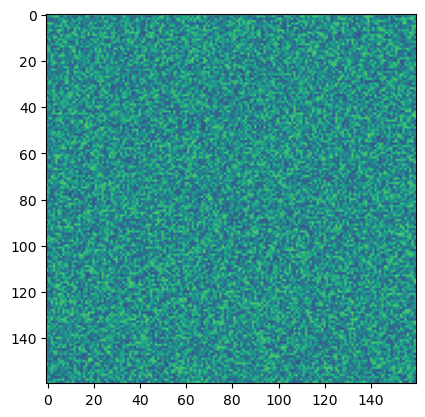

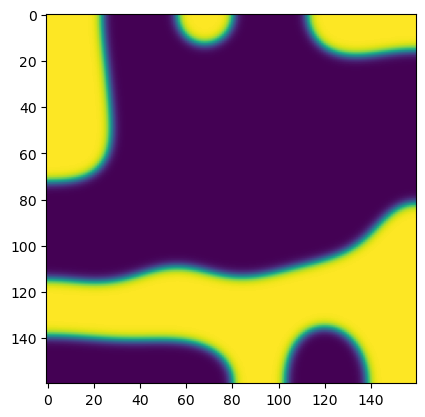

In [3]:
# import one of William's solutions
# from solutions.allencahn_spectral import AllenCahn
# from solutions.allencahn import AllenCahn

## Run an example simulation and plot the before and after
np.random.seed(0)
ic = np.random.random((160, 160)) - 0.5
model = AllenCahn(*ic.shape, kappa=1e1, d=1e-3)
tpts, sol = model.solve(ic, 0, 8, 400, method="DOP853")


plt.figure()
plt.imshow(sol[0], vmin=-1, vmax=1)

plt.figure()
plt.imshow(sol[-1], vmin=-1, vmax=1)

#### 2. Describe how varying $D$ and $\kappa$ change the properties of your solution. Is this consistent with your intuition for special cases in which this equation is solvable?


We can run the above method for varying $D$ and $\kappa$ values here and then just plot the solutions:

In [4]:
## Run an example simulation and plot the before and after
np.random.seed(0)
ic = np.random.random((160, 160)) - 0.5

kappas = [1e-1, 1e0, 1e1, 1e2]
ds = [1e-4, 1e-3, 1e-2, 1e-1]

diff_kappa_solns = []
diff_d_solns = []

for kappa in kappas: 
    model = AllenCahn(*ic.shape, kappa=kappa, d=1e-3)
    tpts, sol = model.solve(ic, 0, 8, 100, method="DOP853")
    diff_kappa_solns.append(sol)

for d in ds:
    model = AllenCahn(*ic.shape, kappa=1e1, d=d)
    tpts, sol = model.solve(ic, 0, 8, 100, method="DOP853")
    diff_d_solns.append(sol)

Plotting the final solutions for the various $\kappa$ values, fixing $d$ at $1e-3$:

Text(0.5, 1.0, 'kappa = 1e2')

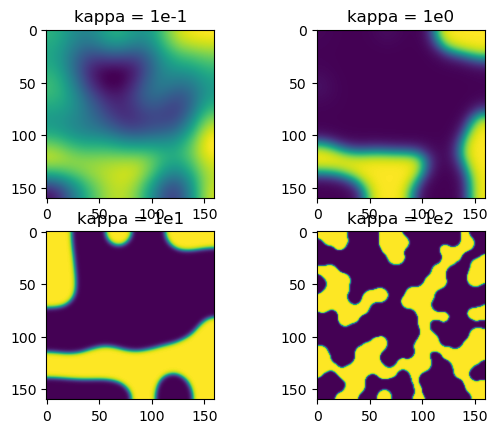

In [5]:
figure, axis = plt.subplots(2, 2)
axis[0,0].imshow(diff_kappa_solns[0][-1])
axis[0,0].set_title("kappa = 1e-1")
axis[0,1].imshow(diff_kappa_solns[1][-1])
axis[0,1].set_title("kappa = 1e0")
axis[1,0].imshow(diff_kappa_solns[2][-1])
axis[1, 0].set_title("kappa = 1e1")
axis[1,1].imshow(diff_kappa_solns[3][-1])
axis[1,1].set_title("kappa = 1e2")

Now plotting the final solutions for various $d$ values while fixing $\kappa$ at $1e1$: 

Text(0.5, 1.0, 'd = 1e-1')

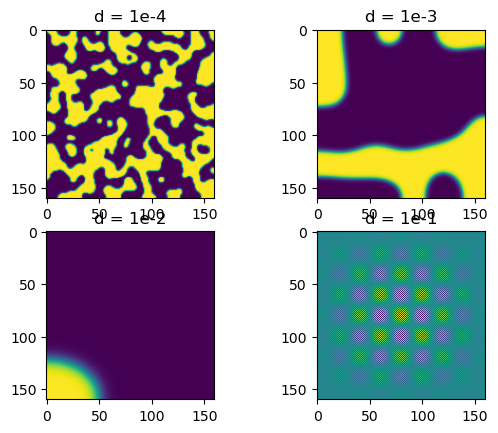

In [6]:
figure, axis = plt.subplots(2, 2)
axis[0,0].imshow(diff_d_solns[0][-1])
axis[0, 0].set_title("d = 1e-4")
axis[0,1].imshow(diff_d_solns[1][-1])
axis[0, 1].set_title("d = 1e-3")
axis[1,0].imshow(diff_d_solns[2][-1])
axis[1, 0].set_title("d = 1e-2")
axis[1,1].imshow(diff_d_solns[3][-1])
axis[1, 1].set_title("d = 1e-1")

For small $\kappa$ (say 1e-1) we already see the diffusive term take over by comparison and everything grows really fuzzy, and on the other hand if we increase $\kappa$ then our final solution becomes more ordered. Similarly, if we decrease $D$ then the reaction term takes over and we reach a more patterned phase, and increasing $d$ to $1e-2$ again makes a fuzzy, diffusive phase. By $d = 1e-1$ we're seeing numerical noise in the dots and not really a good solution, so by increasing the diffusivity too much we see a failed solution.

#### 3. Try changing the mesh size, integration timestep, or integration duration. Under what conditions does the solver fail? What do failures look like for this solution method?


Again I'm just going to write a loop that runs over a few different values for all of this. I expect first that if we make $dt$ too large then we'll reach a failure. Integrating over longer periods shouldn't affect stability unless we've messed with $dt$, and finally making a courser mesh will make the problem run faster but give a less-resolved solution (so really just a worse solution). I also don't recommend re-running the blocks below as some took a minute or so to finish running. 

In [7]:
## Run an example simulation and plot the before and after
np.random.seed(0)
ic = np.random.random((160, 160)) - 0.5

total_steps = [10, 100, 200, 400, 600]
Tmaxs = [8, 10, 12, 14]

diff_timesteps = []
diff_int_times = []
diff_meshes = []

First I adjust the total number of points between $t_{min}$ and $t_{max}$:

In [8]:
for steps in total_steps: 
    model = AllenCahn(*ic.shape, kappa=1e1, d=1e-3)
    tpts, sol = model.solve(ic, 0, 8, steps, method="DOP853")
    diff_timesteps.append(sol)

This block is adjusting the $t_{max}$ value but keeping the number of points between $t_{min}$ and $t_{max}$ the same:

In [9]:
for Tmax in Tmaxs:
    model = AllenCahn(*ic.shape, kappa=1e1, d=1e-3)
    tpts, sol = model.solve(ic, 0, Tmax, 100, method="DOP853")
    diff_int_times.append(sol)

Lastly, we adjust the grid spacing:

In [10]:
np.random.seed(0)

grid_size = [10, 50, 100, 160]

for nx in grid_size:
    ic = np.random.random((nx, nx)) - 0.5
    model = AllenCahn(*ic.shape, kappa=1e1, d=1e-3)
    tpts, sol = model.solve(ic, 0, 8, 100, method="DOP853")
    diff_meshes.append(sol)

The first results are for varying $nt$, so the number of time steps between $t_{min}$ and $t_{max}$. We don't really see any changes in the figures for different $nt$ values.

Text(0.5, 1.0, 'Nt = 400')

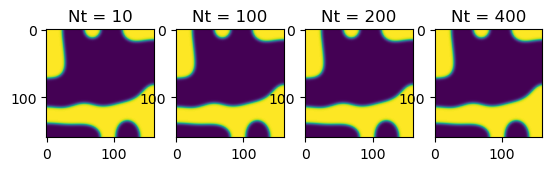

In [24]:
figure, axis = plt.subplots(1, 4)

axis[0].imshow(diff_timesteps[0][-1])
axis[0].set_title("Nt = 10")

axis[1].imshow(diff_timesteps[1][-1])
axis[1].set_title("Nt = 100")

axis[2].imshow(diff_timesteps[2][-1])
axis[2].set_title("Nt = 200")

axis[3].imshow(diff_timesteps[3][-1])
axis[3].set_title("Nt = 400")

Next we look at the results for altering the final time value $t_{max}$, here we see something change as we change the integration time, specifically the solution continues to slowly diffuse. Still haven't found an instance of the solution failing though.

Text(0.5, 1.0, 'Tmax = 14')

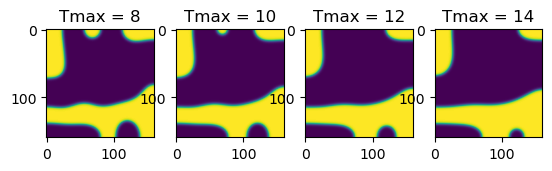

In [25]:
figure, axis = plt.subplots(1, 4)

axis[0].imshow(diff_int_times[0][-1])
axis[0].set_title("Tmax = 8")

axis[1].imshow(diff_int_times[1][-1])
axis[1].set_title("Tmax = 10")

axis[2].imshow(diff_int_times[2][-1])
axis[2].set_title("Tmax = 12")

axis[3].imshow(diff_int_times[3][-1])
axis[3].set_title("Tmax = 14")

Lastly, we look at what happens when we change the grid spacing. As expected for a coarse grid we get a really coarse solution, and as we increase the resolution we reach a point where it's about as clear as it's going to be (specifically, the resolution on the solutions for 100 by 100 and 160 by 160 are esentially the same, there wasn't really a benefit to increasing the grid size)

Text(0.5, 1.0, '160 by 160 Grid')

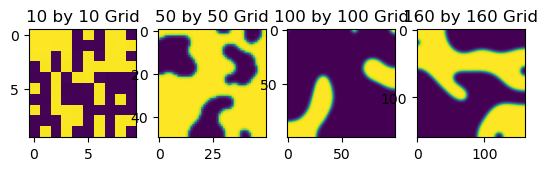

In [26]:
figure, axis = plt.subplots(1, 4)

axis[0].imshow(diff_meshes[0][-1])
axis[0].set_title("10 by 10 Grid")

axis[1].imshow(diff_meshes[1][-1])
axis[1].set_title("50 by 50 Grid")

axis[2].imshow(diff_meshes[2][-1])
axis[2].set_title("100 by 100 Grid")

axis[3].imshow(diff_meshes[3][-1])
axis[3].set_title("160 by 160 Grid")

#### 4.  If you are familiar with Photoshop, you have probably used a tool called a ["Gaussian blur,"](https://www.youtube.com/watch?v=ri8RVzhHYoA) which blurs image details in a manner reminiscent of camera blur. This method is occasionally used in the analysis of experimental microscopy images, or even one-dimensional time series, in order to remove high-frequency information. The results of a Gaussian blur of fixed radius look very reminiscent of applying the raw diffusion equation ($\kappa=0$) to our initial conditions for a fixed duration. Based on what you know about analytical results for the heat equation, can you guess why this might be the case? What kind of photo-editing operation does the reaction term in our system mimic?

The Allen-Cahn equation without the reaction term is just the heat equation, and as we saw before when we increase $D$ without changing $\kappa$ it's enough to get a much blurrier result. If the reaction term doesn't exist then this effect will be even more prominent. 

The reaction term probably goes along with the sharpening effect in photoshop. 

## Problem 2


#### 1. Implement the Gray-Scott equations in Python, using the spectral method and the method of lines. I've included the outline of my solution below, but feel free to structure your code differently. Use periodic boundary conditions here, because the Fourier transform requires them.
    -- Note that there are several possible ways to solve this problem: (1) exclusively in real-space (it's good practice not to use this approach here, since we already did it above for the Allen-Cahn model), (2) primarily in real-space, but switching to the Fourier domain and back within every call to the diffusion term, or (3) primarily working in the Fourier domain but switching back-and-forth to real space every time within the reaction term. If you opt for the last option, remember to convert your final solution back to real space.
    -- You will likely find the functions `np.fft.fft2()` and `np.fft.ifft2()` very useful here


In [14]:
from scipy.integrate import solve_ivp

class GrayScott:
    """
    Simulate the two-dimensional Gray-Scott model

    Parameters
        nx (int): number of grid points in the x direction
        ny (int): number of grid points in the y direction
        Lx (float): length of the domain in the x direction
        Ly (float): length of the domain in the y direction
        du (float): diffusion coefficient for u
        dv (float): diffusion coefficient for v
        kappa (float): degradation rate of v
        b (float): growth rate of u

    """

    def __init__(self, nx, ny, du=0.1, dv=0.05, b=0.0545, kappa=0.1165, Lx=1.0, Ly=1.0):
        self.nx, self.ny = nx, ny
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.du, self.dv = du, dv
        self.kappa = kappa
        self.b = b
        
        ## We need to define a mesh for the frequency domain
        kx = (2 * np.pi / Lx) * np.hstack([np.arange(nx / 2 + 1), np.arange(1 - nx / 2, 0)]) / nx
        ky = (2 * np.pi / Ly) * np.hstack([np.arange(ny / 2 + 1), np.arange(1 - ny / 2, 0)]) / ny
        self.kx, self.ky = kx, ky
        kxx, kyy = np.meshgrid(kx, ky)

        ksq = kxx**2 + kyy**2
        self.ksq = ksq

        
    def _reaction(self, y):
        """
        Compute the reaction term in real space

        Args:
            y (np.ndarray): array of shape (2 * nx * ny, ) containing the two fields
                u and v, stacked together
        """
        
        u = y[:self.nx * self.ny]
        v = y[-self.nx * self.ny:]

        u_reaction = -u * v**2 +  self.b * (1 - u)
        v_reaction = u * v**2 - self.kappa * v

        return np.hstack([u_reaction, v_reaction])

    def _laplace(self, y):
        """
        Calculate the Laplacian in Fourier space
        """
        
        y = np.reshape(y, (self.nx, self.ny))

        y_fourier = np.fft.fft2(y)

        laplacian_fourier = -self.ksq * y_fourier 

        laplacian = np.fft.ifft2(laplacian_fourier)

        return np.real(laplacian).flatten()
        

    def _diffusion(self, y):
        """
        Calculate the diffusion term in Fourier space

        Args:
            y (np.ndarray): array of shape (2 * nx * ny, ) containing the two fields
                u and v, stacked together
        """
        u = y[:self.nx * self.ny]
        v = y[-self.nx * self.ny:]

        u_laplacian = self._laplace(u)
        v_laplacian = self._laplace(v) 

        u_diff = self.du * u_laplacian
        v_diff = self.dv * v_laplacian 

        return np.hstack([u_diff, v_diff])


    def rhs(self, t, y):
        """
        For technical reasons, this function needs to take a one-dimensional vector, 
        and so we have to reshape the vector back into the mesh
        """
        
        return self._reaction(y) + self._diffusion(y)


    def solve(self, y0, t_min, t_max, nt, **kwargs):
        """
        Solve the heat equation using the solve_ivp solver

        Args:
            y0 (np.ndarray): initial condition
            t_min (float): minimum time
            t_max (float): maximum time
            nt (int): number of time steps
            **kwargs: keyword arguments to pass to solve_ivp

        """
        
        u0, v0 = y0

        t_vals = np.linspace(t_min, t_max, nt)

        y0 = np.hstack([u0.flatten(), v0.flatten()])

        solution = solve_ivp(self.rhs, (t_min, t_max), y0, t_eval = t_vals, **kwargs)

        soln = solution.y.T

        u = soln[:, :self.nx * self.ny]
        v = soln[:, -self.nx * self.ny:]

        u = np.reshape(u, (nt, self.nx, self.ny))
        v = np.reshape(v, (nt, self.nx, self.ny))

        return t_vals, np.stack([u, v], axis = -1)

Imaginary residual is: 0.0


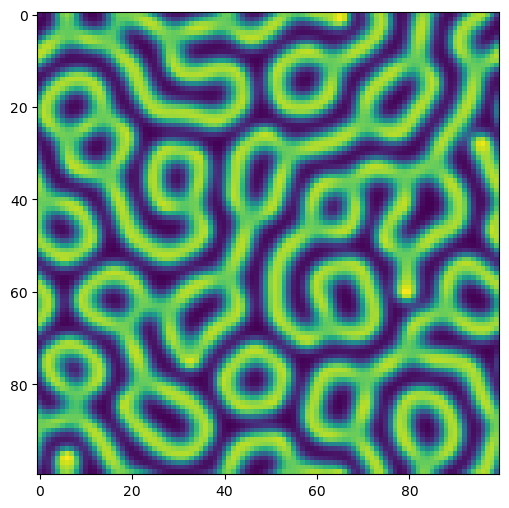

In [15]:
## Create initial conditions
np.random.seed(0)
u_ic = 0.5 +  1.5 * np.random.random((100, 100))
v_ic = 1 - np.copy(u_ic)

## Run simulation
model = GrayScott(*u_ic.shape)
tpts, sol = model.solve([u_ic, v_ic], 0, 5000, 500)

## Check that our spectral code is working: the imaginary residual should be small
print(f"Imaginary residual is: {np.mean(np.abs(np.imag(np.array(sol))))}")
sol = np.real(sol)

plt.figure(figsize=(6, 6))
plt.imshow(sol[-1, ..., 1])

#### 2. Try varying the parameters $D_u$, $D_v$ and $\beta$ in your equations. How do the solutions change? Do you have any intuition for why these changes might occur?


Just copying and pasting the code from above, we can look at a few different solutions for different parameter values. First changing $D_u$ to be $0.5$ we see the following (and a forewarning that this took my computer a minute and a half to run):

Imaginary residual is: 0.0


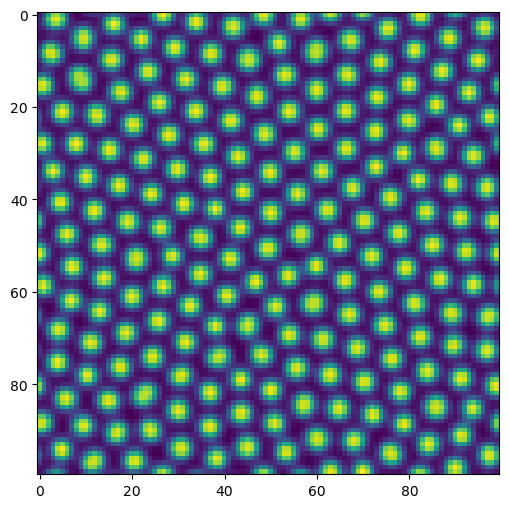

In [19]:
model = GrayScott(du = 0.5, *u_ic.shape)
tpts, sol = model.solve([u_ic, v_ic], 0, 5000, 500)

## Check that our spectral code is working: the imaginary residual should be small
print(f"Imaginary residual is: {np.mean(np.abs(np.imag(np.array(sol))))}")
sol = np.real(sol)

plt.figure(figsize=(6, 6))
plt.imshow(sol[-1, ..., 1])

The solution now is significantly more patterned but interestingly the pattern doesn't exist on a grid, it's still slightly disordered, and we didn't even change by a whole order of magnitude. We can try adjusting $D_v$, i.e. setting $D_v = 0.1$ to make this term larger:

Imaginary residual is: 0.0


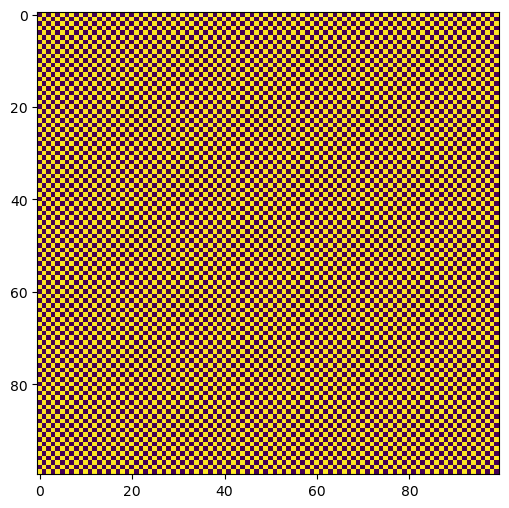

In [21]:
model = GrayScott(dv = 0.1, *u_ic.shape)
tpts, sol = model.solve([u_ic, v_ic], 0, 5000, 500)

## Check that our spectral code is working: the imaginary residual should be small
print(f"Imaginary residual is: {np.mean(np.abs(np.imag(np.array(sol))))}")
sol = np.real(sol)

plt.figure(figsize=(6, 6))
plt.imshow(sol[-1, ..., 1])

Again it became much more structured, as more grid cells take on a yellow color. I like this one because it forms a checkboard! If we instead decrease diffusivity in $u$:

Imaginary residual is: 0.0


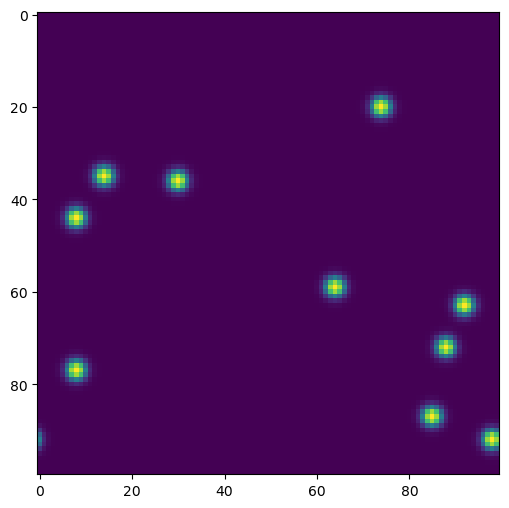

In [22]:
model = GrayScott(du = 0.07, *u_ic.shape)
tpts, sol = model.solve([u_ic, v_ic], 0, 5000, 500)

## Check that our spectral code is working: the imaginary residual should be small
print(f"Imaginary residual is: {np.mean(np.abs(np.imag(np.array(sol))))}")
sol = np.real(sol)

plt.figure(figsize=(6, 6))
plt.imshow(sol[-1, ..., 1])

we instead lose the pattern and shift to largely being a single color so more ordered. Lastly, I looked at what happens when we decrease $D_v$:

Imaginary residual is: 0.0


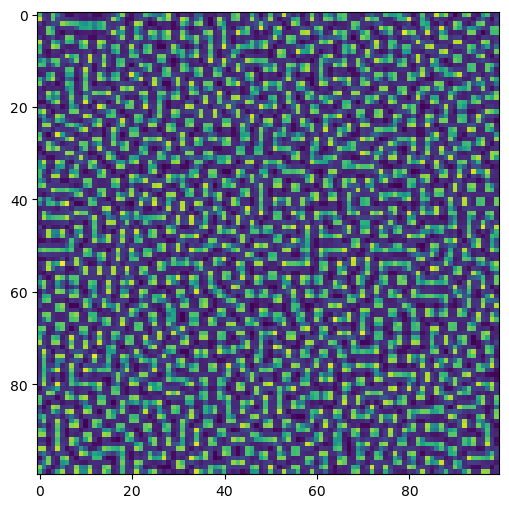

In [23]:
model = GrayScott(dv = 0.01, *u_ic.shape)
tpts, sol = model.solve([u_ic, v_ic], 0, 5000, 500)

## Check that our spectral code is working: the imaginary residual should be small
print(f"Imaginary residual is: {np.mean(np.abs(np.imag(np.array(sol))))}")
sol = np.real(sol)

plt.figure(figsize=(6, 6))
plt.imshow(sol[-1, ..., 1])

The solution again takes on a pattern that isn't quite on a grid but still really interesting. I didn't find solutions that were failures, but I did originally choose parameter values that cause my solver to just continually run and potentially not converge, which I would take as a failed solution. Since I didn't let them run to completion, I'm not sure what the solutions looked like but all it took was changing values $D_v$ and $D_u$ by one order of magnitude to create this situation. I would assume we just are making the diffusivity too large/too small by doing this, and the solution we might have converged to would look like a solid color with some numerical noise, much like what happened in the first question when I made $d$ larger. 

#### 3. We mentioned that performing Fourier transforms at each timestep is more expensive per mesh point than computing the discrete Laplacian at each timestep. Can you give a more mathematical reason for this advantage, based on runtime scaling of Fourier transforms? How many fewer mesh points would we need to compensate?


#### 4. Try playing around with the number of timepoints and the number of space points. When does the spectral method fail? How do these failures differ from the ones we saw with the real-space finite difference scheme we used for the Allen-Cahn equations?


I'll edit my code to run over a few different options for grid size and the number of time points below. I really don't recommend trying to rerun these blocks as they took some time to actually finish!

In [27]:
## Create initial conditions
np.random.seed(0)

In [36]:
# Here I run over a few different nx and ny values, but I'm keeping my grid a square. Other than this
# I'm leaving the original parameters untouched.

nxs = [10, 50, 80, 100, 150] 
diff_grid_size = []

for nx in nxs:
    u_ic = 0.5 +  1.5 * np.random.random((nx, nx))
    v_ic = 1 - np.copy(u_ic)
    ## Run simulation
    model = GrayScott(*u_ic.shape)
    tpts, sol = model.solve([u_ic, v_ic], 0, 5000, 500)

    diff_grid_size.append(sol)

Imaginary residual is: 0.0
Imaginary residual is: 0.0
Imaginary residual is: 0.0
Imaginary residual is: 0.0
Imaginary residual is: 0.0


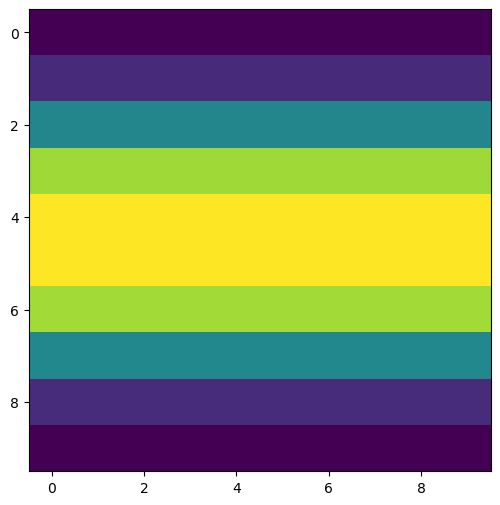

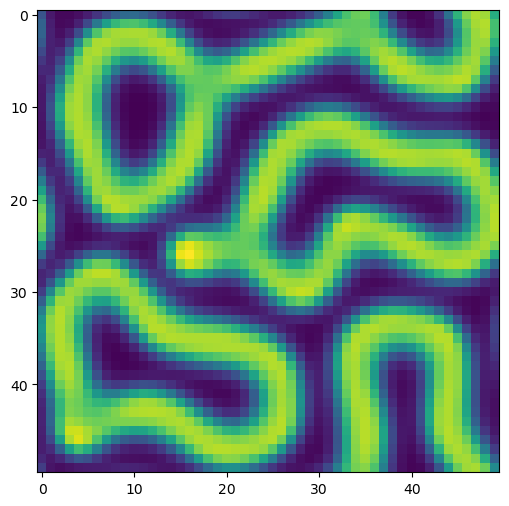

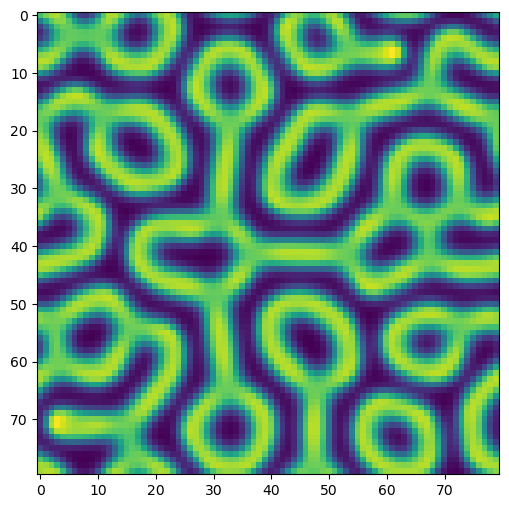

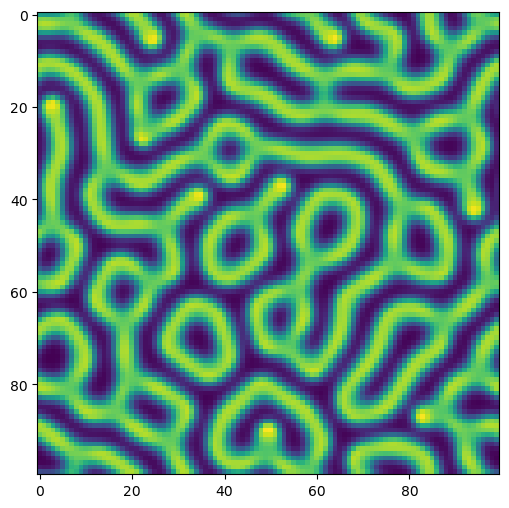

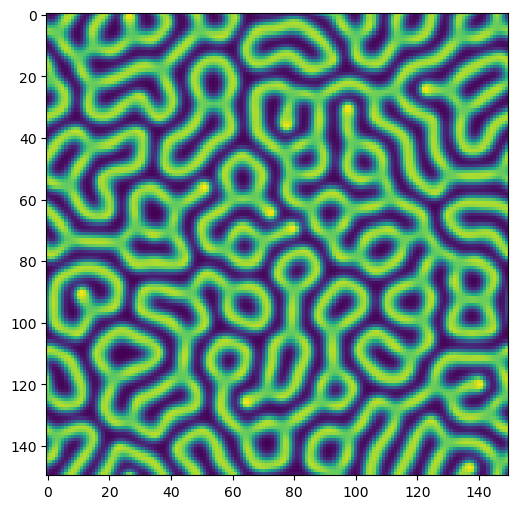

In [37]:
## Check that our spectral code is working: the imaginary residual should be small

for sol in diff_grid_size:
    print(f"Imaginary residual is: {np.mean(np.abs(np.imag(np.array(sol))))}")
    sol = np.real(sol)

    plt.figure(figsize=(6, 6))
    plt.imshow(sol[-1, ..., 1])

For the coarsest grid (nx = ny = 10) we see one bad solution, but this is expected when we choose so few grid cells. For all other grid sizes we don't really see a failed solution we just see the pattern getting tighter and more dense (more pattern per area). This makes sense as increasing resolution in the grid should increase the resolution in the solution we get out. The results for changing nt values are below:

In [38]:
# Now we can go over a few different nt values 

nts = [100, 200, 500, 700] 
diff_time_steps = []

for nt in nts:
    u_ic = 0.5 +  1.5 * np.random.random((100, 100))
    v_ic = 1 - np.copy(u_ic)
    ## Run simulation
    model = GrayScott(*u_ic.shape)
    tpts, sol = model.solve([u_ic, v_ic], 0, 5000, nt)

    diff_time_steps.append(sol)

Imaginary residual is: 0.0
Imaginary residual is: 0.0
Imaginary residual is: 0.0
Imaginary residual is: 0.0


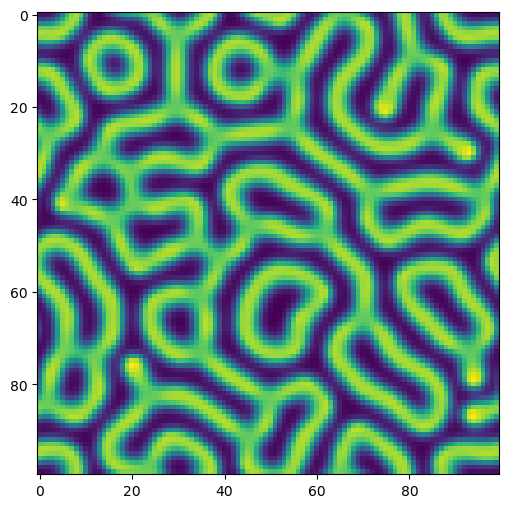

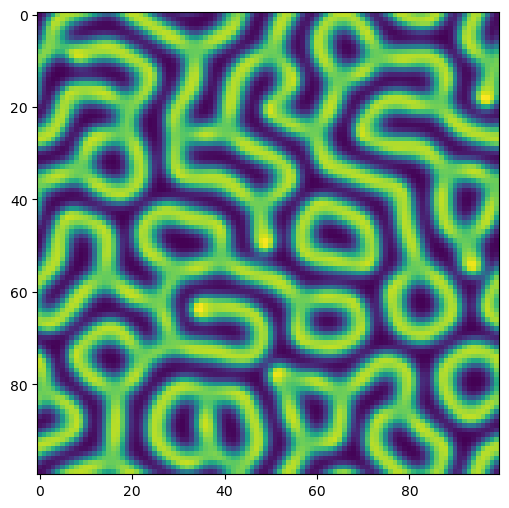

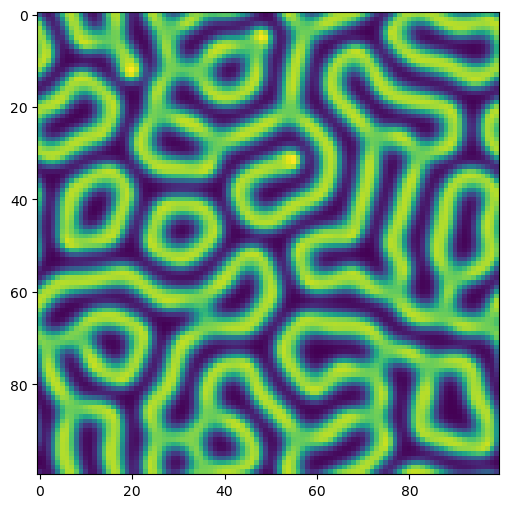

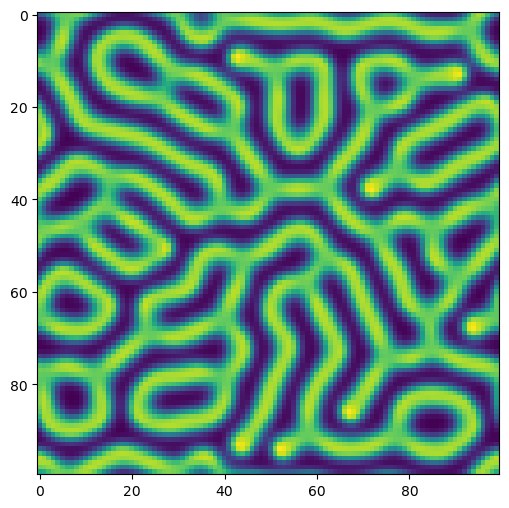

In [40]:
## Check that our spectral code is working: the imaginary residual should be small

for sol in diff_time_steps:
    print(f"Imaginary residual is: {np.mean(np.abs(np.imag(np.array(sol))))}")
    sol = np.real(sol)

    plt.figure(figsize=(6, 6))
    plt.imshow(sol[-1, ..., 1])

At first I didn't really see a change in any of these, but upon closer inspection we just see the pattern shift. Pieces that previously were disconnected become connected and vice versa. I again don't see any failed solutions, even for only 100 points between 0 and 5000. 

#### 5. Evolutionary biologists recently showed strong evidence that [the spacing of teeth-like denticles on sharks' skin](https://www.science.org/doi/10.1126/sciadv.aau5484?cookieSet=1) arises from a Turing mechanism. If we suppose that the denticles form via a Turing instability in Gray-Scott equations in early development, which parameter of the Gray-Scott equations would evolutionary forces most strongly act upon?


The pictures in that paper look like the solution I got when I increased $D_u$, so I'd guess that the diffusivity term in $\dot{u}$ would be affected the most.

#### 6. We assumed periodic boundary conditions, which makes this problem easier to implement. How do you expect our results would change, if we had Dirichlet boundary conditions?


I'd expect the work that would need to be done in frequency space to be much more difficult if we didn't implement periodic boundary conditions. I also know this because I tried running my code with Dirichlet conditions instead and the solver didn't even finish after 5 minutes. 